# Walmart Sales Forecasting

This notebook downloads the Walmart dataset (Kaggle), performs EDA, builds features, trains models (baseline, Linear, RF, XGBoost), evaluates by RMSE/MAE/MAPE, and saves the best model.


In [4]:
!pip install -q kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import kagglehub
import os


### Cell 1 — Intro

Predict weekly Walmart sales using time-series + regression techniques. **bold text**

In [5]:
# Download dataset directly via KaggleHub
path = kagglehub.dataset_download("yasserh/walmart-dataset")

# Find the CSV file
csv_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".csv")]
csv_files


Using Colab cache for faster access to the 'walmart-dataset' dataset.


['/kaggle/input/walmart-dataset/Walmart.csv']

### **Cell 3 — Read Main CSV**

In [6]:
df = pd.read_csv(csv_files[0])
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### **Cell 4 — Quick EDA**

In [7]:
print(df.info())
print(df.isnull().sum())
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Holiday_Flag,6435.0,6.993007e-02,0.255049,0.000,0.000,0.000000,0.000000e+00,1.000000e+00
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


###**Cell 5 — Preprocessing**

In [9]:
# Fix date format (day-month-year)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Sort by date
df = df.sort_values('Date')

# Fill missing values safely
df.fillna(df.mean(numeric_only=True), inplace=True)

# Create new time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)


### **Cell 6 — Feature Selection and Split**

In [11]:
# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Choose features dynamically based on available columns
possible_features = ['Store', 'Dept', 'Year', 'Month', 'Week',
                     'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Only use columns that actually exist
features = [col for col in possible_features if col in df.columns]

X = df[features]
y = df['Weekly_Sales']

# Split data into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Using features:", features)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Columns in dataset: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week']
Using features: ['Store', 'Year', 'Month', 'Week', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Train shape: (5148, 8) Test shape: (1287, 8)


### **Cell 7 — Train Model and Evaluate**

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


MAE: 62047.92
RMSE: 124063.09
R²: 0.951


### **Cell 8 — Visualization**

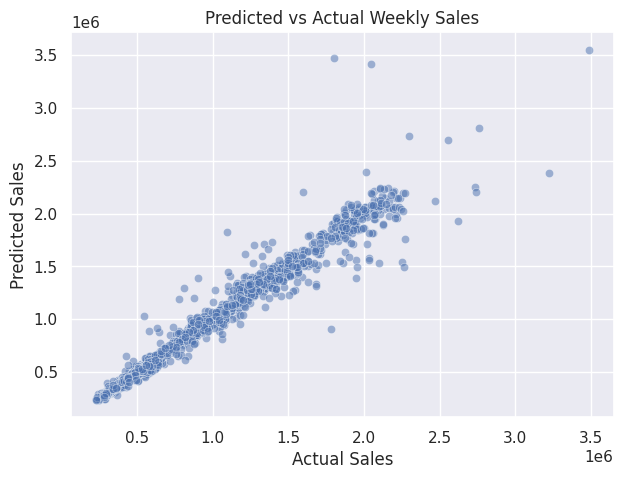

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Weekly Sales")
plt.show()
